# Contents

1. [Background](#1)
2. [Setup the Environment](#2)
3. [Prepare the Data](#3)
4. [Algorithm Comparison](#4)

Sample Code for use of the Gluonts Python library in AWS Sagemaker Notebook Instance to benchmark popular time series forecast Algorithms, including 

* [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
* [Prophet](https://facebook.github.io/prophet/docs/quick_start.html)
* [DeepAR](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html)

amazon-sagemaker-forecast-algorithms-benchmark-using-gluonts.ipynb gives an example on how to compare forecast algorithms on a dataset by only using the Gluonts library.

* The Jupyter notebook should be run in a AWS Sagemker Notebook Instance (ml.m5.4xlarge is recommended)
* Pls use the conda_python3 kernel.

# <a name=1></a> 1. Background

Time series forecast is a very common problem in many real-world applications. A wide spectrum of(一系列） algorithms have been proposed to solve this problem. However, it is usually difficult to benchmark different algorithms and compare their performance due to the various implementation of the algorithms. This notebook tries to show an example how to benchmark different time series forecast algorithms by only using the Glutonts library.

只用Glutonts库来比较不同的算法，作为基准

# <a name=2></a> 2. Setup the Environment

## 2.1 install R for extenal r forecast algorithms

In [121]:
# # intall the missing lib for R
# !sudo yum install libXt-1.1.4-6.1.9.amzn1.x86_64 -y

In [122]:
# # install python r interface
# !conda install -c r rpy2==2.9.4 --yes

In [123]:
# # install forecast R packages
# !R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'

## 2.2 Install Python Pacakages

In [124]:
# # install Prophet python packages
# !conda install -c plotly plotly==3.10.0 --yes
# !conda install -c conda-forge fbprophet=0.5=py36he1b5a44_0 --yes

In [125]:
# !conda install -c anaconda ujson=1.35=py36h14c3975_0 --yes

In [126]:
# # install gluonts
# !pip install gluonts==0.4.2

In [127]:
# # install mxnet
# !pip install mxnet==1.4.1

In [128]:
# !pip install fbprophet

## 2.3 import libraries

In [261]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
import zipfile
import mxnet as mx

from urllib.request import urlretrieve

from gluonts.model.trivial.mean import MeanPredictor
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

In [130]:
# fix some plot issues caused by Prophet model
# pls refer to https://darektidwell.com/typeerror-float-argument-must-be-a-string-or-a-number-not-period-facebook-prophet-and-pandas/
pd.plotting.register_matplotlib_converters()

In [131]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
mx.random.seed(42)

# <a name=3></a> 3. Prepare the Data

Import electricity dataset, we need to download the original data set of from the UCI data set repository.

## 3.1 Download data

In [132]:
DATA_HOST = "https://archive.ics.uci.edu"
DATA_PATH = "/ml/machine-learning-databases/00321/"
ARCHIVE_NAME = "LD2011_2014.txt.zip"
FILE_NAME = ARCHIVE_NAME[:-4]

In [133]:
def progress_report_hook(count, block_size, total_size):
    mb = int(count * block_size // 1e6)
    if count % 500 == 0:
        sys.stdout.write("\r{} MB downloaded".format(mb))
        sys.stdout.flush()

if not os.path.isfile(FILE_NAME):
    print("downloading dataset (258MB), can take a few minutes depending on your connection")
    urlretrieve(DATA_HOST + DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME, reporthook=progress_report_hook)

    print("\nextracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_NAME, 'r')
    zip_ref.extractall("./")
    zip_ref.close()
else:
    print("File found skipping download")

File found skipping download


In [134]:
data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=',')
num_timeseries = data.shape[1]
data_kw = data.resample('2H').sum() / 8 # 2H小时采样，每个小时包含4条数据，2H，除以8表示取均值
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f')) # np.trim_zeros，把0的值去除掉

In [263]:
data.shape,num_timeseries

((140256, 370), 370)

In [136]:
data.head() # 原始数据包含了370个观测对象，时间步是15分钟

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
data.tail() # 原始数据包含了370个观测对象，时间步是15分钟

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [138]:
data.index.min(),data.index.max()

(Timestamp('2011-01-01 00:15:00'), Timestamp('2015-01-01 00:00:00'))

In [139]:
data_kw.shape,len(timeseries) # data_kw是按照两个小时采样，timeseries是一个list

((17533, 370), 370)

In [140]:
timeseries[0].shape,timeseries[1].shape

((13153,), (13153,))

In [141]:
[timeseries[i].shape for i in range(100) if timeseries[i].shape[0] != 13153] # 每个timeseries中的非0值数量并不是相同的

[(5874,),
 (6906,),
 (12080,),
 (7218,),
 (9306,),
 (10818,),
 (5455,),
 (5694,),
 (8396,)]

In [142]:
any(i == 0 for i in timeseries[0].values)

False

In [143]:
timeseries[0] # 这是一个series

2012-01-01 00:00:00    3.648477
2012-01-01 02:00:00    4.600254
2012-01-01 04:00:00    4.600254
2012-01-01 06:00:00    4.441624
2012-01-01 08:00:00    2.538071
                         ...   
2014-12-31 16:00:00    2.379442
2014-12-31 18:00:00    2.220812
2014-12-31 20:00:00    2.379442
2014-12-31 22:00:00    2.062183
2015-01-01 00:00:00    0.317259
Freq: 2H, Name: MT_001, Length: 13153, dtype: float64

In [260]:
len(timeseries)

370

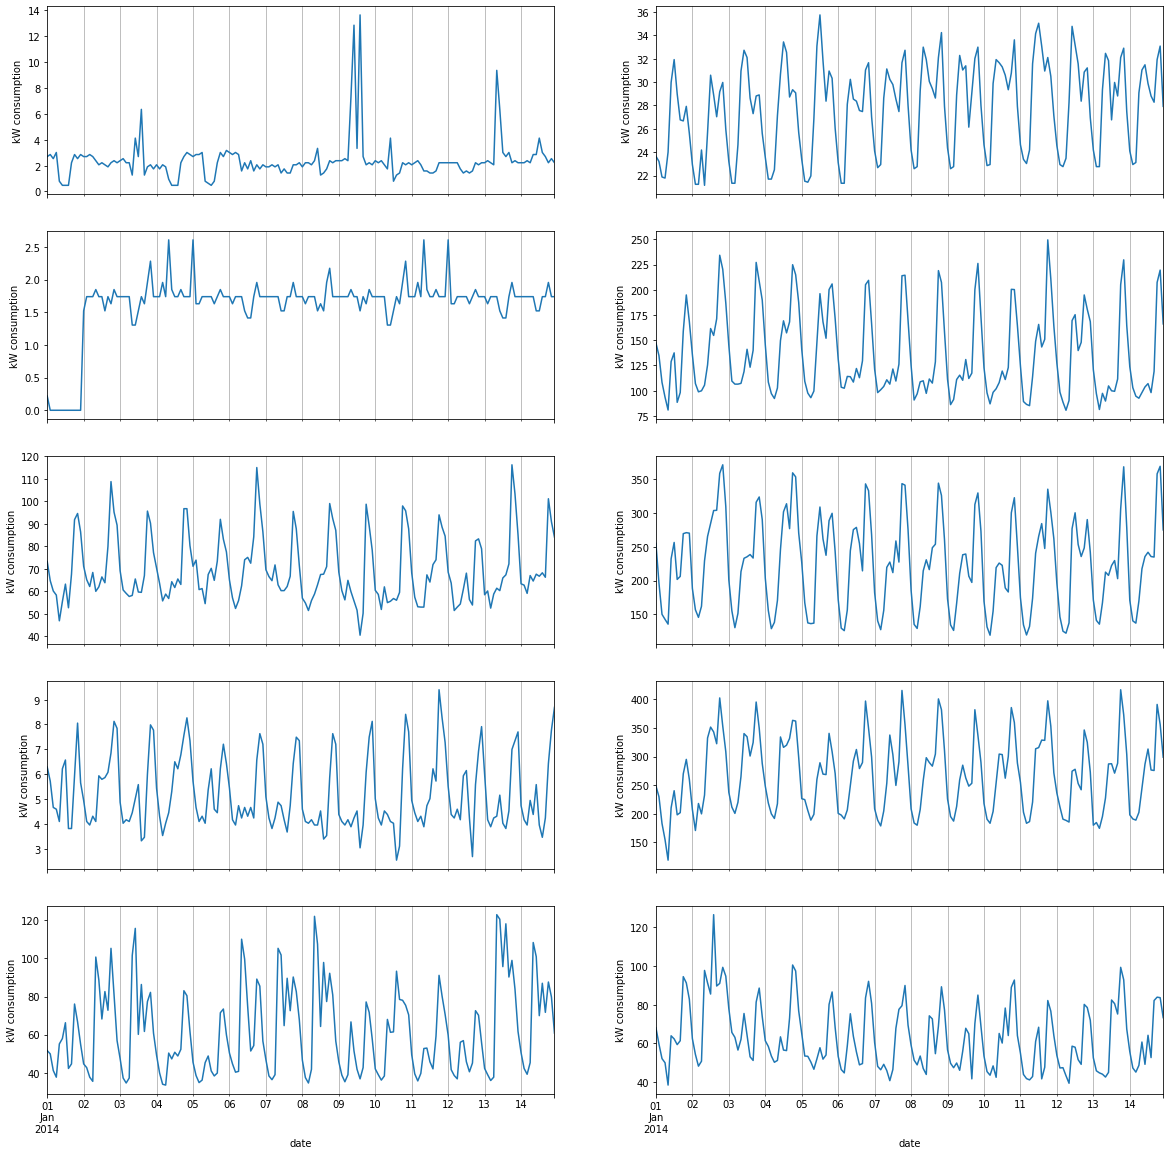

In [144]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")    # kW - 千瓦
    axx[i].grid(which='minor', axis='x')

## 3.2 Train Test Data Split

In [145]:
def split_train_test_data(timeseries,
                          start_dataset,
                          end_training,
                          num_test_windows):
    # create training data.
    # TODO:这儿要不要－１,待考虑
    # 每个序列都要形成一个list存储起来
    training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1 * end_training.freq].tolist(),  # We use -1, because pandas indexing includes the upper bound,剔除了2014-09-01 00:00:00
        "feat_static_cat": [id] # 刚好每一行属于１个
    }
    for id, ts in enumerate(timeseries)
    ]
    
    # create testing data.
    test_data = [
        {
            "start": str(start_dataset),
            "target": ts[start_dataset:end_training + k * (prediction_length -1)* end_training.freq ].tolist(),
            "feat_static_cat": [id]
        }
        for k in range(1, num_test_windows + 1)
        for id, ts in enumerate(timeseries)
    ]
    
    return training_data, test_data

In [198]:
# we use 2 hour frequency for the time series
freq = '2H'

# we predict for 1 day
# 预测1天 = 12*2 = 24Ｈ
prediction_length = 1 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
# 用７天的数据
context_length = 7 * 12

# The moving window for forecast
num_test_windows = 1

# training/test Split
# 原始数据集:(Timestamp('2011-01-01 00:15:00'), Timestamp('2015-01-01 00:00:00'))
start_dataset = pd.Timestamp("2014-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2014-09-01 00:00:00", freq=freq)

# number of time series selected
# 作为示例，只考虑了５０个序列，总计len(timeseries)＝370
n_timeseries = 50

In [188]:
print(start_dataset,end_training - 1 * end_training.freq)

2014-01-01 00:00:00 2014-08-31 22:00:00


In [148]:
print(start_dataset,end_training + 1 * (prediction_length-1) * end_training.freq)

2014-01-01 00:00:00 2014-09-01 22:00:00


In [201]:
print(start_dataset,end_training + 2 * (prediction_length-1) * end_training.freq)

2014-01-01 00:00:00 2014-09-02 20:00:00


In [202]:
print(start_dataset,end_training + 3 * (prediction_length-1) * end_training.freq)

2014-01-01 00:00:00 2014-09-03 18:00:00


In [199]:
training_data, test_data = split_train_test_data(timeseries[:n_timeseries],
                          start_dataset,
                          end_training,
                          num_test_windows)

In [200]:
len(training_data),len(test_data) # 只考虑了５０个序列

(50, 150)

In [194]:
len(training_data[0]['target']),len(test_data[0]['target']) 

(2916, 2928)

In [195]:
len(training_data[1]['target']),len(test_data[1]['target'])

(2916, 2928)

In [154]:
2928 - 2916

12

# <a name=4></a> 4. Algorithm Comparison

In [156]:
def train_and_test(training_data, 
                   test_data,
                   freq,
                   num_test_windows,
                   model,
                   train_per_ts=False,
                   require_train=False
                   ):
    forecasts = [] #预测值（Forecast对象）
    tss = [] # 实际的序列
    
    # if training per time series is required.
    # 把单个序列拿出来，做训练和预测
    if train_per_ts:
        # iterate over the timeseries
        count = 0
        for training_ts in training_data:
            # get the training time series
            training_ts = ListDataset(
                      [training_ts],
                      freq = freq
            )
            # get the related testing time series
            test_tss = test_data[count*num_test_windows: (count+1)*num_test_windows]

            test_tss = ListDataset(
                test_tss,
                freq = freq
            )
            if require_train:
                predictor = model.train(training_data=training_ts)
            else:
                predictor = model
            
            forecast_it, ts_it = make_evaluation_predictions(test_tss, predictor=predictor, num_samples=100)
            forecasts.extend(list(forecast_it))
            tss.extend(list(ts_it))
            count += 1
    else:
        # 直接把全部序列拿进来做训练和预测
        training_data = ListDataset(
                      training_data,
                      freq = freq
            )
        test_data = ListDataset(
            test_data,
            freq = freq
        )
        if require_train:
            predictor = model.train(training_data=training_data)
        else:
            predictor = model
        
        forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=100)
        forecasts.extend(list(forecast_it))
        tss.extend(list(ts_it))
        
    return forecasts, tss

## 4.1 Training and Testing

###  Mean

In [224]:
%%time
# 直接以均值做预测(均值算法不需要训练，但是train_per_ts=True)
mean= MeanPredictor(freq=freq, prediction_length=prediction_length,
                                  context_length=context_length)
forecasts_mean, tss_mean = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               mean,#传入的model
               train_per_ts=True,
               require_train=False
               )

CPU times: user 237 ms, sys: 4.01 ms, total: 241 ms
Wall time: 240 ms


### Seaonal Naive

In [158]:
%%time
# SeasonalNaivePredictor算法不需要训练，但是train_per_ts=True
seasonal = SeasonalNaivePredictor(freq=freq,
                                  prediction_length=prediction_length,
                                  season_length=context_length)
forecasts_seasonal, tss_seasonal = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               seasonal,#传入的model
               train_per_ts=True,
               require_train=False
               )

CPU times: user 87.3 ms, sys: 9 µs, total: 87.3 ms
Wall time: 88.2 ms


### ARIMA

In [159]:
# %%time
# # RForecastPredictor 调用了Ｒ的两个包c("forecast", "nnfor"),
# 注意,arima模型，需要ｔrain_per_ts=True，就是每个序列需要单独训练、预测
# arima = RForecastPredictor(freq=freq,
#                            prediction_length=prediction_length,
#                            method_name='arima')
# forecasts_arima, tss_arima = train_and_test(training_data, 
#                test_data,
#                freq,
#                num_test_windows,
#                arima,#传入的model
#                train_per_ts=True,
#                require_train=False
#                )

### Prophet

In [223]:
# !pip install fbprophet

In [222]:
# !pip install gluonts[Prophet]

In [166]:
# %%time
# prophet = ProphetPredictor(freq, prediction_length)
# 注意,prophet模型，需要ｔrain_per_ts=True，就是每个序列需要单独训练、预测
# forecasts_prophet, tss_prophet = train_and_test(training_data, 
#                test_data,
#                freq,
#                num_test_windows,
#                prophet,
#                train_per_ts=True,
#                require_train=False
#                )

### DeepAR

In [ ]:
%%time
deepar = DeepAREstimator(freq=freq,
                         use_feat_static_cat=True,
                         cardinality=[n_timeseries],
                        prediction_length=prediction_length,
                        trainer=Trainer(epochs=100,ctx="gpu(0)"),
                        num_cells=40)
forecasts_deepar, tss_deepar = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               deepar,
               train_per_ts=False,
               require_train=True
               )

## 4.2 Results

### Evaluation

In [168]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_mean, item_metrics_mean = evaluator(iter(tss_mean), iter(forecasts_mean), num_series=len(forecasts_mean))
print(agg_metrics_mean)

Running evaluation: 100%|██████████| 50/50 [00:00<00:00, 270.22it/s]


{'MSE': 2796.319856862026, 'abs_error': 13896.796532288501, 'abs_target_sum': 62475.69932556152, 'abs_target_mean': 104.12616554260254, 'seasonal_error': 12.020438583626232, 'MASE': 1.8224525900864317, 'MAPE': 0.24346968093595248, 'sMAPE': 0.25035220669516745, 'OWA': nan, 'MSIS': 72.89810360345724, 'QuantileLoss[0.5]': 13896.796532288501, 'Coverage[0.5]': 0.47999999999999976, 'RMSE': 52.880240703518226, 'NRMSE': 0.5078477674459512, 'ND': 0.22243522973423874, 'wQuantileLoss[0.5]': 0.22243522973423874, 'mean_wQuantileLoss': 0.22243522973423874, 'MAE_Coverage': 0.02000000000000024}


In [169]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss_seasonal), 
                                                        iter(forecasts_seasonal), 
                                                        num_series=len(forecasts_seasonal))
print(agg_metrics_seasonal)

Running evaluation: 100%|██████████| 50/50 [00:00<00:00, 335.16it/s]


{'MSE': 1503.8846358060837, 'abs_error': 9214.831570625305, 'abs_target_sum': 62475.69932556152, 'abs_target_mean': 104.12616554260254, 'seasonal_error': 12.020438583626232, 'MASE': 1.0973131163647332, 'MAPE': 0.16872436071012392, 'sMAPE': 0.16590318364837006, 'OWA': nan, 'MSIS': 43.89252434481134, 'QuantileLoss[0.5]': 9214.831554412842, 'Coverage[0.5]': 0.30500000000000005, 'RMSE': 38.77995146729923, 'NRMSE': 0.37243233979870954, 'ND': 0.14749465264256942, 'wQuantileLoss[0.5]': 0.1474946523830691, 'mean_wQuantileLoss': 0.1474946523830691, 'MAE_Coverage': 0.19499999999999995}


In [171]:
# evaluator = Evaluator(quantiles=[0.5], seasonality=None)
# agg_metrics_arima, item_metrics_arima = evaluator(iter(tss_arima), 
#                                                         iter(forecasts_arima), 
#                                                         num_series=len(forecasts_arima))
# print(agg_metrics_arima)

In [173]:
# evaluator = Evaluator(quantiles=[0.5], seasonality=None)
# agg_metrics_prophet, item_metrics_prophet = evaluator(iter(tss_prophet), 
#                                                         iter(forecasts_prophet), 
#                                                         num_series=len(forecasts_prophet))
# print(agg_metrics_prophet)

In [174]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_deepar, item_metrics_deepar = evaluator(iter(tss_deepar), 
                                                        iter(forecasts_deepar), 
                                                        num_series=len(forecasts_deepar))
print(agg_metrics_deepar)

Running evaluation: 100%|██████████| 50/50 [00:00<00:00, 317.66it/s]


{'MSE': 888.5905806216869, 'abs_error': 7773.9478142261505, 'abs_target_sum': 62475.69932556152, 'abs_target_mean': 104.12616554260254, 'seasonal_error': 12.020438583626232, 'MASE': 0.988034445555957, 'MAPE': 0.13704424491101164, 'sMAPE': 0.15601809314340026, 'OWA': nan, 'MSIS': 39.52137745649526, 'QuantileLoss[0.5]': 7773.947901129723, 'Coverage[0.5]': 0.3616666666666667, 'RMSE': 29.809236498469513, 'NRMSE': 0.286279979130445, 'ND': 0.12443154535519525, 'wQuantileLoss[0.5]': 0.12443154674619325, 'mean_wQuantileLoss': 0.12443154674619325, 'MAE_Coverage': 0.1383333333333333}


In [175]:
df_metrics = pd.concat(
    [
        pd.DataFrame.from_dict(agg_metrics_deepar, orient='index').rename(columns={0: "DeepAR"}),
#      pd.DataFrame.from_dict(agg_metrics_prophet, orient='index').rename(columns={0: "Prophet"}),
#      pd.DataFrame.from_dict(agg_metrics_arima, orient='index').rename(columns={0: "ARIMA"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"}),
    pd.DataFrame.from_dict(agg_metrics_mean, orient='index').rename(columns={0: "Mean"})], axis=1
)
df_metrics.loc[["MASE", "RMSE", "sMAPE"]]

,DeepAR,Seasonal naive,Mean
MASE,0.988034,1.097313,1.822453
RMSE,29.809236,38.779951,52.880241
sMAPE,0.156018,0.165903,0.250352


### Plot Example Forecast

In [185]:
def plot_forecasts(tss, forecasts, past_length, start, stop, step, title):
    for target, forecast in islice(zip(tss, forecasts), start, stop, step):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='r')
        plt.title(title)
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

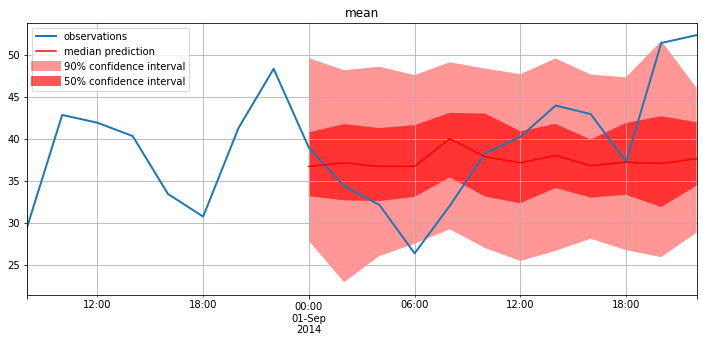

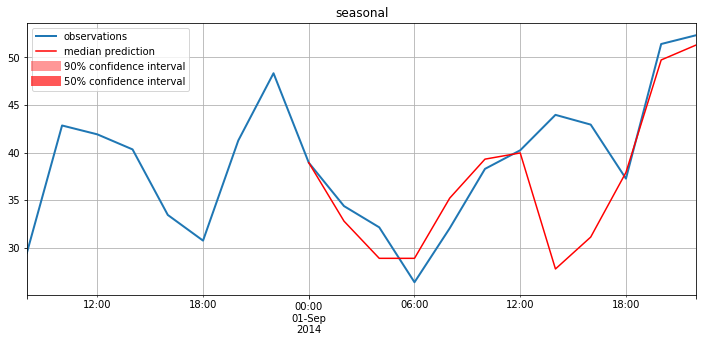

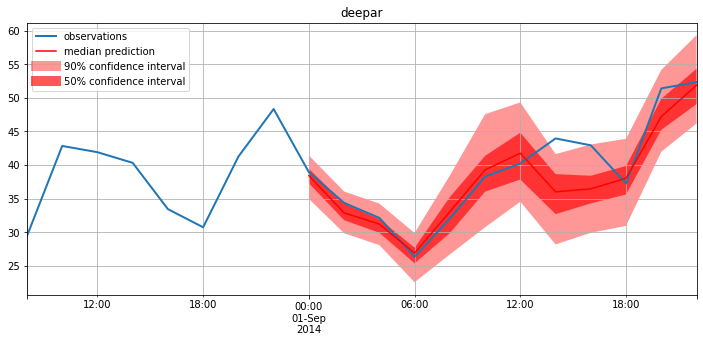

In [228]:
start, stop, step = 10, 11, 1 # 控制输出的内容
plot_forecasts(tss_mean, forecasts_mean, past_length=20, start=start, stop=stop, step=step, title="mean")
plot_forecasts(tss_seasonal, forecasts_seasonal, past_length=20, start=start, stop=stop, step=step, title="seasonal")
# plot_forecasts(tss_arima, forecasts_arima, past_length=100, start=start, stop=stop, step=step, title="arima")
# plot_forecasts(tss_prophet, forecasts_prophet, past_length=100, start=start, stop=stop, step=step, title="prophet")
plot_forecasts(tss_deepar, forecasts_deepar, past_length=20, start=start, stop=stop, step=step, title="deepar")